# Compare various VAEs side-by-side on CelebA (GSOC 2021)

Author: [Ang Ming Liang](https://github.com/Neoanarika).
Mentor: [Kevin Murphy](https://www.cs.ubc.ca/~murphyk/).

This notebook uses pre-trained models (checkpoints) that are stored in githib/ GCS.
For details on how these were created, see 
https://github.com/probml/pyprobml/tree/master/scripts/vae#instruction-for-training-the-model





# Setup

In [1]:
#@title Setup for colab { display-mode: "form" }

%%capture
!sudo apt-get install subversion
!svn checkout https://github.com/probml/pyprobml/trunk/vae .
!pip install pytorch-lightning einops
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!rm kaggle.json
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/download_celeba.py
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/two_stage_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/hinge_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/info_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/logcosh_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/mmd_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/vanilla_vae_celeba_conv.ckpt
!wget -q https://storage.googleapis.com/probml_data/vae_checkpoints/vq_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/sigma_vae_celeba_conv.ckpt
!wget -q https://storage.googleapis.com/probml_data/vae_checkpoints/pixel_cnn_celeba_conv.ckpt
!wget -q https://storage.googleapis.com/probml_data/vae_checkpoints/beta_vae_celeba_conv.ckpt
!wget -q https://storage.googleapis.com/probml_data/vae_checkpoints/vanilla_ae_celeba_conv.ckpt

**Warning**: If you are running this on your local machine please follow the readme instructions to first download the subdirectory before using this notebook, instead of running the "setup for colab" file.

In [ ]:
#@title Run Setup And Installation { display-mode: "form" }

import torch
import warnings
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from download_celeba import celeba_dataloader
from assembler import get_config, assembler
from utils.plot import plot_reconstruction, plot_samples
from utils.interpolation import vector_of_interest, get_imrange

warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def make_model(model_name, use_gpu=False):
  fname = f"./configs/{model_name}.yaml"
  config = get_config(fname)
  vae = assembler(config, "inference")
  if use_gpu: vae = vae.to("cuda")
  return vae

def make_and_load_models(model_names: list, use_gpu=False):
  vaes = []
  for model_name in model_names:
    vae = make_model(model_name, use_gpu)
    vae.load_model()
    vaes.append(vae)
  return vaes 

# Download data and load data module

### Get kagggle.json file so you can access the dataset
Follow [these instructions](https://github.com/Kaggle/kaggle-api#api-credentials) to get a kaggle.json key file. Then upload it to colab using the follow script.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
#@title Download celeba and load datamodule { display-mode: "form" }
!python download_celeba.py

bs = 512
IMAGE_SIZE = 64
CROP = 128
lr = 1e-3
epochs= 1
latent_dim = 256
DATA_PATH = "kaggle"

dm = celeba_dataloader(bs, IMAGE_SIZE, CROP, DATA_PATH)



Files exist already
I0817 20:25:39.749969 140446056925056 utils.py:157] NumExpr defaulting to 2 threads.
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


Global seed set to 42


Files exist already


In [ ]:
import pytorch_lightning as pl
pl.seed_everything(99)
dm.setup() # force make data loaders n

batch = next(iter(dm.train_dataloader()))
x, y = batch 

Global seed set to 99


# Comparing results

In [ ]:
!mkdir figures
figdir = 'figures'

mkdir: cannot create directory ‘figures’: File exists


In [ ]:
models_to_compare = ["vanilla_ae", "vanilla_vae", "beta_vae", "info_vae", "hinge_vae", "mmd_vae", "logcosh_vae", "two_stage_vae", "sigma_vae", "vq_vae"]
figsize_reconstruction = (10, 30)
figsize_samples = (10, 10)

vaes = make_and_load_models(models_to_compare, use_gpu = True)

## Reconstruction

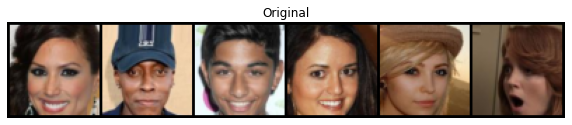

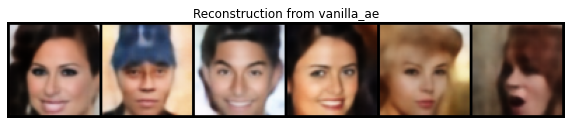

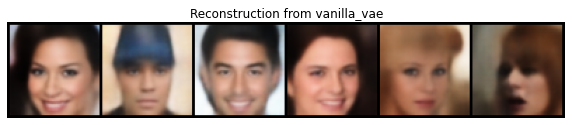

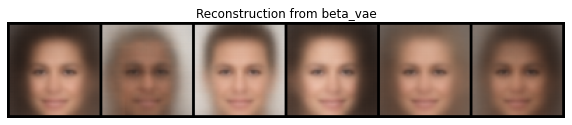

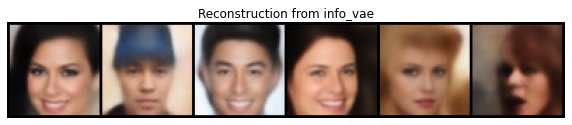

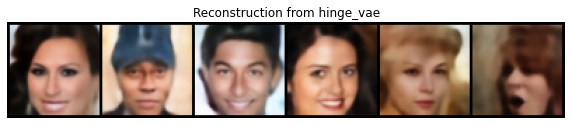

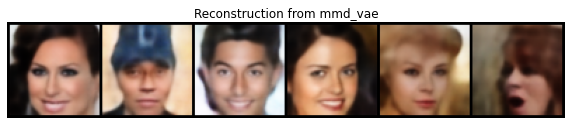

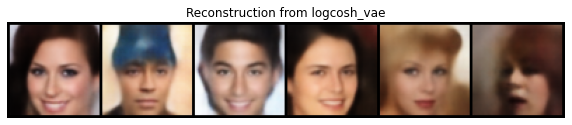

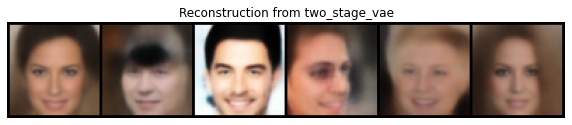

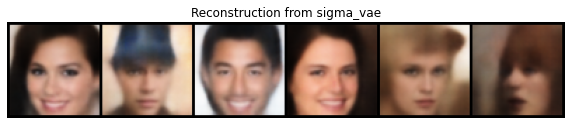

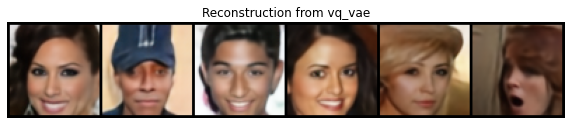

In [ ]:
# deterministic given batch
num_imgs = 6
plot_reconstruction(vaes, batch, num_of_samples=num_imgs, num_of_images_per_row=num_imgs, figdir=figdir)

## Samples

Global seed set to 42


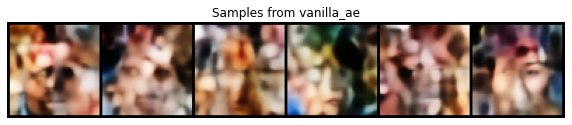

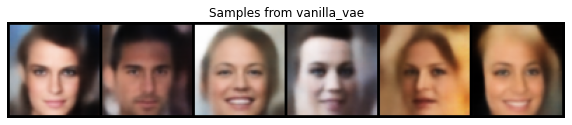

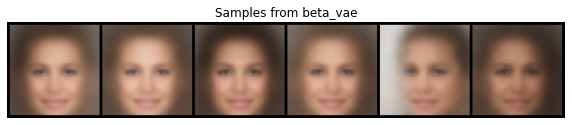

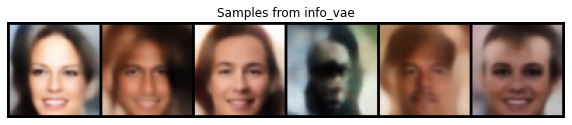

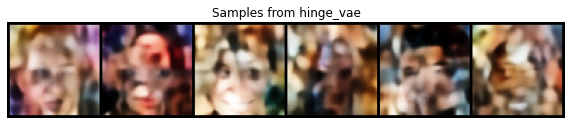

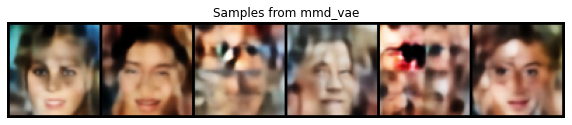

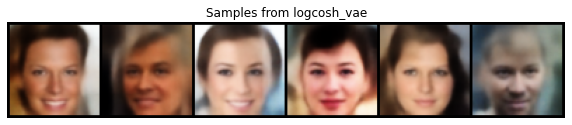

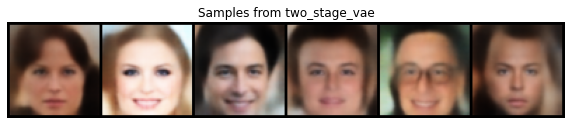

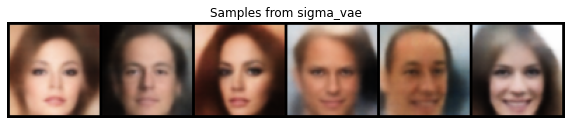

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


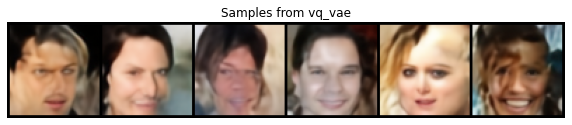

In [ ]:
pl.seed_everything(42)

vaes = make_and_load_models(models_to_compare, use_gpu = True)

num_imgs = 6
num_of_images_per_row = 6 

plot_samples(vaes, num=num_imgs, num_of_images_per_row=num_of_images_per_row, figdir=figdir)

## Interpolation

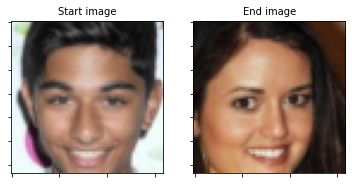

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


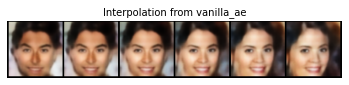

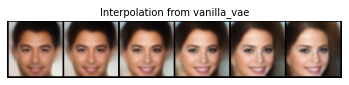

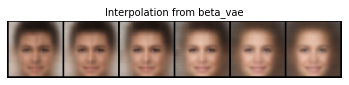

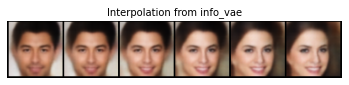

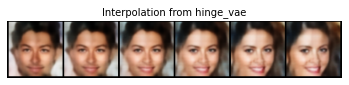

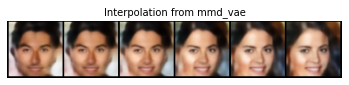

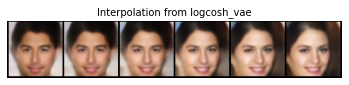

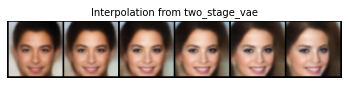

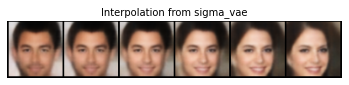

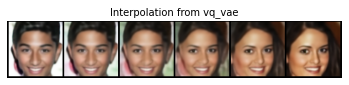

In [ ]:
# deterministic given batch
from einops import rearrange
feature_of_interest="Male"
vec3, male, female = vector_of_interest(vaes[0], batch, feature_of_interest)

start_img = torch.reshape(male[1], [1, 3, 64, 64])
end_img = torch.reshape(female[1], [1, 3, 64, 64])

fig , axs = plt.subplots(1,2)
axs[0].set_title("Start image", fontsize=10)
axs[0].imshow(rearrange(start_img, "b c h w -> h w (c b)"))
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])
axs[1].imshow(rearrange(end_img, "b c h w -> h w (c b)"))
axs[1].set_title("End image", fontsize=10)
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])

if figdir is not None:
    filename = f'{figdir}/vae-interpolate-original.png'
    plt.savefig(filename, bbox_inches="tight")
plt.show()

for vae in vaes:
  plt.figure() #figsize=(20,10))
  plt.title(f"Interpolation from {vae.model_name}", fontsize=10)
  arr = get_imrange(vae.decode, vae.det_encode(start_img), vae.det_encode(end_img), nums=6, interpolation="linear")
  plt.axis('off')
  plt.imshow(arr)
  if figdir is not None:
    filename = f'{figdir}/vae-interpolate-{vae.model_name}.png'
    plt.savefig(filename, bbox_inches="tight")

plt.show()

## Save figures

In [ ]:
!ls figures

vae-interpolate-beta_vae.png	   vae-recon-original.png
vae-interpolate-hinge_vae.png	   vae-recon-sigma_vae.png
vae-interpolate-info_vae.png	   vae-recon-two_stage_vae.png
vae-interpolate-logcosh_vae.png    vae-recon-vanilla_ae.png
vae-interpolate-mmd_vae.png	   vae-recon-vanilla_vae.png
vae-interpolate-original.png	   vae-recon-vq_vae.png
vae-interpolate-sigma_vae.png	   vae-samples-beta_vae.png
vae-interpolate-two_stage_vae.png  vae-samples-hinge_vae.png
vae-interpolate-vanilla_ae.png	   vae-samples-info_vae.png
vae-interpolate-vanilla_vae.png    vae-samples-logcosh_vae.png
vae-interpolate-vq_vae.png	   vae-samples-mmd_vae.png
vae-recon-beta_vae.png		   vae-samples-sigma_vae.png
vae-recon-hinge_vae.png		   vae-samples-two_stage_vae.png
vae-recon-info_vae.png		   vae-samples-vanilla_ae.png
vae-recon-logcosh_vae.png	   vae-samples-vanilla_vae.png
vae-recon-mmd_vae.png		   vae-samples-vq_vae.png


In [ ]:
!rm /content/vae-figs.zip
!zip -r /content/vae-figs.zip /content/figures


  adding: content/figures/ (stored 0%)
  adding: content/figures/vae-recon-original.png (deflated 0%)
  adding: content/figures/vae-interpolate-two_stage_vae.png (deflated 0%)
  adding: content/figures/vae-samples-vq_vae.png (deflated 0%)
  adding: content/figures/vae-interpolate-hinge_vae.png (deflated 0%)
  adding: content/figures/vae-samples-mmd_vae.png (deflated 0%)
  adding: content/figures/vae-interpolate-beta_vae.png (deflated 0%)
  adding: content/figures/vae-recon-mmd_vae.png (deflated 0%)
  adding: content/figures/vae-samples-beta_vae.png (deflated 1%)
  adding: content/figures/vae-recon-info_vae.png (deflated 0%)
  adding: content/figures/vae-interpolate-vanilla_ae.png (deflated 0%)
  adding: content/figures/vae-recon-vanilla_ae.png (deflated 0%)
  adding: content/figures/vae-interpolate-vanilla_vae.png (deflated 0%)
  adding: content/figures/vae-samples-two_stage_vae.png (deflated 0%)
  adding: content/figures/vae-recon-hinge_vae.png (deflated 0%)
  adding: content/figures/

In [ ]:
from google.colab import files
files.download("/content/vae-figs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>